In [1]:
!pip install open3d

In [2]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import math
import scipy
from tqdm import tqdm_notebook

In [3]:
pcd = o3d.io.read_point_cloud("sb_2011.pts")

In [4]:
point_cloud_in_numpy = np.asarray(pcd.points)
point_cloud_in_numpy 

array([[ -1.8312, -17.1466,  -3.8058],
       [ -1.6594, -17.1458,  -3.8238],
       [ -1.6594, -17.1454,  -3.8015],
       ...,
       [  0.1304,   7.9499,   1.2323],
       [  0.1398,   7.9496,   1.1724],
       [  0.1397,   7.9439,   1.1815]])

In [44]:
o3d.visualization.draw_geometries([o3d.io.read_point_cloud("sb_2011.pts")])

# NDT

Был вариант, для инициализации А использовать VoxelGrid, но я так и не придумала, как вытащить оттуда соотношение кубик-массив точек в нем, поэтому делим каждую координату нацело на s, получаем координаты кубика для каждой точки.

In [8]:
s = 0.5
te = 0.01
A = point_cloud_in_numpy // s # разбиение PCD на кубики
Q = np.array([0, 0, 0]) # плоские NDT ячейки
Q_points = []
P = [] # остальные ячейки

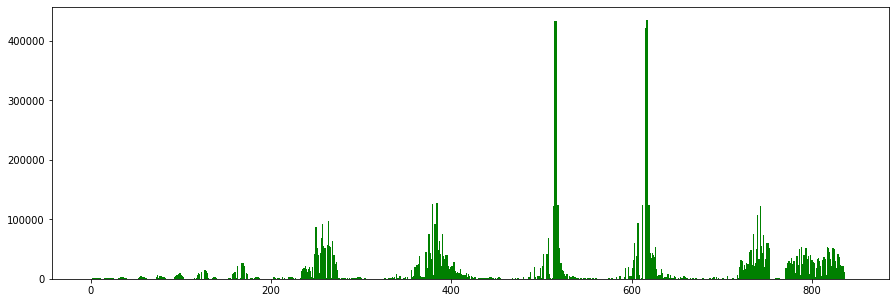

In [9]:
unique,counts=np.unique(A,axis=0, return_counts=True)
plt.figure(figsize=(15,5))
plt.bar(range(0, len(counts)), counts, width=1.5, color='g')
plt.show()

In [10]:
def IRLS_find_norm(points):
    cov = np.cov(np.array(points).T)
    #print("cov = ", cov)
    lambd, e = np.linalg.eig(cov)
    e = e.T
    o = lambd.argsort()
    lambd = lambd[o]
    e = e[o]
    gamma = 1e-6
    k_w = 2.985
    n = e[0]
    g = np.mean(points, axis = 0)
    X_prev = np.zeros(3)
    for i in range(100):
        n_old = n
        r = (points - g) @ n
        w = np.exp(-(r ** 2 / k_w ** 2))
        X_k = np.average(points - g - X_prev, axis=0, weights=w)
        vec = (points - g - X_k)
        X_prev = X_k
        C = (vec.T * w) @ vec
        w, v = np.linalg.eig(C)
        v = v.T
        o = w.argsort()
        w = w[o]
        v = v[o]
        n = v[0]
        convg = np.linalg.norm(n_old - n) / np.linalg.norm(n_old)
        if convg < gamma:
            break
    return n

In [11]:
mu = []
normals = []
for ind, i in tqdm_notebook(list(enumerate(unique))):
    this_cell = np.array(point_cloud_in_numpy[np.where(np.prod(A == i, axis = -1))])
    if (len(this_cell) <= 3):
        P.append(this_cell)
        continue
    mu.append(np.mean(this_cell))
    cov = np.cov(np.array(this_cell).T)
    #print("cov = ", cov)
    w, v = np.linalg.eig(cov)
    v = v.T
    o = w.argsort()
    w = w[o]
    v = v[o]
    #print("values = ", w)
    if (abs(w[0] / w[1]) <= te):
        Q = np.vstack((Q, i))
        Q_points.append(list(this_cell))
        normals.append(IRLS_find_norm(this_cell))
    else:
        P.append(list(this_cell))
Q = Q[1:,]
P = np.concatenate(P)

C:\Users\Demonex\anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
Q_points = np.array(Q_points)
normals = np.array(normals)
print(np.shape(normals))

(373, 3)


# RANSAC

In [105]:
def plane(Q, P, Q_points, normals):
    k_max = 50
    nu = 0.95
    delta_d = 0.08
    n = 0
    delta_theta = 0.25
    k = 0
    Psi = np.zeros(len(Q), dtype=np.bool)
    Psi_size = 0
    Psi_points = []
    k = 1
    while k < k_max:
        c = np.random.choice(range(0, len(Q)))
        cell = Q[c]
        points = Q_points[c]
        gk = np.mean(points, axis = 0)
        nk = normals[c]
        Ik = np.zeros(len(Q), dtype=np.bool)
        cnt = 0
        Ik_points = []
        for i, v in enumerate(Q):
            g_i = np.mean(Q_points[i], axis = 0)
            n_i = normals[i]
            d_i = np.dot((g_i - gk), nk) / np.linalg.norm(nk)
            theta_i = 1 - np.abs(np.dot(nk, n_i)) / (np.linalg.norm(nk) * np.linalg.norm(n_i))
            if (np.abs(d_i) < delta_d and theta_i < delta_theta):
    #             print(d_i, theta_i)
    #             print(n_i, nk)
                Ik[i] = 1
                cnt += 1
                Ik_points += Q_points[i]
        if cnt > Psi_size:
            Psi = Ik
            Psi_points = Ik_points
            Psi_size = cnt
            n = nk
            g = gk
            Pn = Psi_size / len(Q)
            k_max = math.ceil(math.log(1 - nu) / math.log(1 - Pn))
        k += 1
#     print(Psi_size)


#     print(Psi_points[0])
#     print(np.shape(Psi_points))
    
    P_mask = np.zeros(len(P), dtype=np.bool)
    for j, i in enumerate(P):
        d_i = np.inner(i - g, n) / np.linalg.norm(n)
        if (np.abs(d_i) < delta_d):
            P_mask[j] = 1 
            Psi_points += [i]
    return n, g, np.array(Psi_points), Q[~Psi], Q_points[~Psi], P[~P_mask], normals[~Psi]
#     print(Psi_points[0])
#     print(np.shape(Psi_points))  

In [121]:
def sep(arr):
    l = min(z)
    h = max(z)
    mid = (h + l) / 2
    #print(l, mid, h)
    ind = np.searchsorted(z, mid)
    z1 = z[:ind]
    z2 = z[ind:]
    floors = []
    lwth = 10000
    upth = 100000
    #print(len(z1) / (mid - l))
    #print(len(z2) / (h - mid))
    if len(z1) / (mid - l) > upth:
        floors.append((l, mid))
    elif len(z1) / (mid - l) > lwth:
        floors += sep(z1)
    if len(z2) / (h - mid) > upth:
        floors.append((mid, h))
    elif len(z2) / (h - mid) > lwth:
        floors += sep(z2)
    return floors

In [17]:
Q_old = Q
P_old = P
Q_points_old = Q_points
normals_old = normals

In [18]:
Q = Q_old
P = P_old
Q_points = Q_points_old
normals = normals_old

In [137]:
z = np.sort(point_cloud_in_numpy[:,2])
z = sep(z)
print(z)

[(-3.9994, -0.1886000000000001), (-0.1886000000000001, 3.6222)]


In [151]:
Q = Q_old
P = P_old
Q_points = Q_points_old
normal_points = normals_old
walls_points = np.zeros((0, 3))
walls_colors = np.zeros((0, 3))
walls_normals = np.zeros((0, 3))
floors_points = np.zeros((0, 3))
floors_colors = np.zeros((0, 3))
floors_normals = np.zeros((0, 3))
print(z)
final_f = []
#for i in range(100):
for ind, i in tqdm_notebook(list(enumerate(range(100)))):
    #print(np.shape(normal_points))
    n, g, Psi_points, Q, Q_points, P, normal_points = plane(Q, P, Q_points, normal_points)
    print(n)
#     print(g)
    print(len(Psi_points))
    print(max(Psi_points[:, 2]), min(Psi_points[:, 2]))
    if len(Psi_points) < 10000:
        break
    pcd.points = o3d.utility.Vector3dVector(np.concatenate((floors_points, walls_points)))
    pcd.colors = o3d.utility.Vector3dVector(np.concatenate((floors_colors, walls_colors)))
    theta_i = 1 - np.abs(np.dot([0, 0, 1], n)) / (np.linalg.norm([0, 0, 1]) * np.linalg.norm(n))
    if (theta_i <= 0.15):
        mean_z = np.mean(Psi_points[:,2])
        for j in z:
            if mean_z <= j[1] and mean_z >= j[0]:
                print("1")
                floors_points = np.concatenate((floors_points, Psi_points))
                floors_colors = np.concatenate((floors_colors, np.repeat(np.random.random(3).reshape(1, 3), len(Psi_points), axis = 0)))
                floors_normals = np.concatenate((floors_normals, [n] * len(Psi_points)))
    else:
        print(2)
        walls_points = np.concatenate((walls_points, Psi_points))
        walls_colors = np.concatenate((walls_points, np.repeat(np.random.random(3).reshape(1, 3), len(Psi_points), axis = 0)))
        walls_normals = np.concatenate((walls_normals, [n] * len(Psi_points)))
pcd.points = o3d.utility.Vector3dVector(np.concatenate((floors_points, walls_points)))
pcd.colors = o3d.utility.Vector3dVector(np.concatenate((floors_colors, walls_colors)))
o3d.visualization.draw_geometries([pcd])

[(-3.9994, -0.1886000000000001), (-0.1886000000000001, 3.6222)]


C:\Users\Demonex\anaconda3\lib\site-packages\ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[ 0.00845516 -0.00599421  0.99994629]
4017147
1.4947 1.0383
1
[ 0.00320837 -0.00146436  0.99999378]
852427
-1.4393 -1.6131
1
[-0.9999767  -0.00506661 -0.00457419]
668256
3.0804 -1.5
2
[ 0.03103352 -0.99951027 -0.00401844]
37386
2.5565 -0.9058
2
[-0.99892472 -0.02312075 -0.04018496]
229711
1.602 -1.4471
2
[0.01427167 0.01552212 0.99977767]
49928
1.3944 1.011
1
[-0.99937591 -0.03466984  0.00676765]
636477
1.4325 -1.6241
2
[ 0.02140677 -0.9997349  -0.00847858]
475724
1.4644 -6.2998
2
[-0.01865596  0.99973635  0.01338584]
9618
-0.1202 -1.5


In [91]:
print(walls_points)

[[ -5.3355  -1.1242   1.2476]
 [ -5.2551  -1.2293   1.2419]
 [ -5.2539  -1.2219   1.2412]
 ...
 [ -0.4974 -11.5492   1.1403]
 [ -0.497  -11.5401   1.1537]
 [ -0.497  -11.5402   1.168 ]]


In [140]:
pcd.points = o3d.utility.Vector3dVector(floors_points)
pcd.colors = o3d.utility.Vector3dVector(floors_colors)
o3d.visualization.draw_geometries([pcd])

# Делаем Mesh из стен и потолков с полом

In [154]:
walls = type(pcd)()
walls.points = o3d.utility.Vector3dVector(walls_points)
walls.colors = o3d.utility.Vector3dVector(np.repeat(np.random.random(3).reshape(1, 3), len(Psi_points), axis = 0))
walls.normals = o3d.utility.Vector3dVector(walls_normals)
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(walls, depth=5, width=0, scale=1.1, linear_fit=False)[0]

o3d.visualization.draw_geometries([walls])
bbox = walls.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)
o3d.visualization.draw_geometries([walls])
o3d.io.write_triangle_mesh("walls.ply", walls)

TypeError: write_triangle_mesh(): incompatible function arguments. The following argument types are supported:
    1. (filename: str, mesh: open3d.open3d_pybind.geometry.TriangleMesh, write_ascii: bool = False, compressed: bool = False, write_vertex_normals: bool = True, write_vertex_colors: bool = True, write_triangle_uvs: bool = True, print_progress: bool = False) -> bool

Invoked with: 'walls.ply', geometry::PointCloud with 2047554 points.

In [153]:
floors = type(pcd)()
floors.points = o3d.utility.Vector3dVector(floors_points)
floors.colors = o3d.utility.Vector3dVector(np.repeat(np.random.random(3).reshape(1, 3), len(floors_points), axis = 0))
#floors.normals = o3d.utility.Vector3dVector(floors_normals)
floors.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
print(floors_normals)
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(floors, 
                                                                         depth=5, 
                                                                         width=0, 
                                                                         scale=1.1, 
                                                                         linear_fit=False)[0]
bbox = floors.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)
o3d.visualization.draw_geometries([floors])
o3d.io.write_triangle_mesh("floors.ply", floors)

[[ 0.00845516 -0.00599421  0.99994629]
 [ 0.00845516 -0.00599421  0.99994629]
 [ 0.00845516 -0.00599421  0.99994629]
 ...
 [ 0.01427167  0.01552212  0.99977767]
 [ 0.01427167  0.01552212  0.99977767]
 [ 0.01427167  0.01552212  0.99977767]]


TypeError: write_triangle_mesh(): incompatible function arguments. The following argument types are supported:
    1. (filename: str, mesh: open3d.open3d_pybind.geometry.TriangleMesh, write_ascii: bool = False, compressed: bool = False, write_vertex_normals: bool = True, write_vertex_colors: bool = True, write_triangle_uvs: bool = True, print_progress: bool = False) -> bool

Invoked with: 'floors.ply', geometry::PointCloud with 4919502 points.

# Делаем план помещения

In [90]:
plan = Psi_points[:,0:3:2]
H, xedges, yedges = np.histogram2d(Psi_points[:, 0], Psi_points[:, 2], bins=(range(len(Psi_points)), range(len(Psi_points))))
H = H.T
fig = plt.figure(figsize=(100000, 100000))
ax = fig.add_subplot(132, title='plan', aspect='equal')
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)
plt.show()

ValueError: Image size of 7200000x7200000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 7.2e+06x7.2e+06 with 1 Axes>

In [150]:
walls_2Dpoints = np.copy(walls_points)
walls_2Dpoints[:, 2] = np.zeros(len(walls_2Dpoints))
print(walls_2Dpoints)
pcd.points = o3d.utility.Vector3dVector(walls_2Dpoints)
pcd.colors = o3d.utility.Vector3dVector(np.repeat(np.random.random(3).reshape(1, 3), len(walls_2Dpoints), axis = 0))
o3d.visualization.draw_geometries([pcd])

[[-1.1455 -3.7258  0.    ]
 [-1.1458 -3.7267  0.    ]
 [-1.1463 -3.7283  0.    ]
 ...
 [ 1.0277 -3.7018  0.    ]
 [ 1.02   -3.674   0.    ]
 [ 1.0105 -3.6398  0.    ]]
